**Calibration of the age-stratified deterministic model**

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

# Load required packages

In [60]:
import random
import os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
from datetime import datetime, timedelta
import datetime
import scipy
from scipy.integrate import odeint
from scipy.stats import norm
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

import math
import xarray as xr
import emcee
import json
import corner

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
from covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2
from covid19model.models.utils import draw_sample_COVID19_SEIRD, moving_avg
from covid19model.models.time_dependant_parameter_fncs import ramp_fun, lockdown_func, policies_until_september

from covid19model.optimization.objective_fcns import MLE, ll_poisson

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load timeseries data

<IPython.core.display.Javascript object>


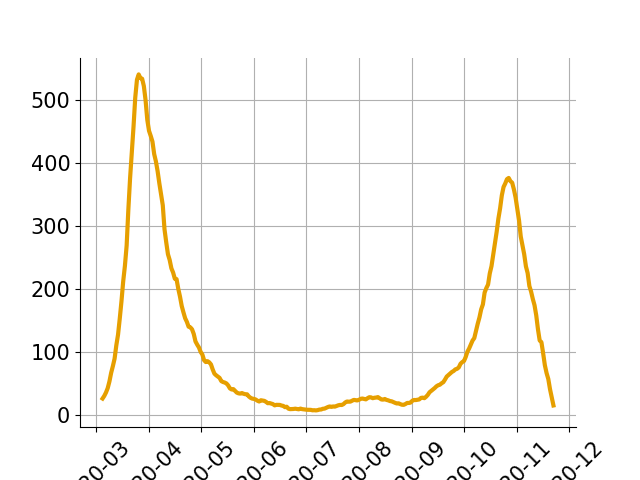

In [69]:
# NOTE: this is private data and can only be loaded when you have access to the 'COVID19_spatial_private' repository

data_file = '../../../COVID19_spatial_private/interim/all_nonpublic_timeseries_prov.csv'
raw_data = pd.read_csv(data_file, sep=',', header=0,  parse_dates = ['DATE'])
raw_data.fillna(0, inplace=True)
data = pd.pivot_table(raw_data, index='DATE', values='hospitalised_IN', aggfunc=np.sum)
timeseries = moving_avg(data,dropna=True)
timeseries.rename(columns={'hospitalised_IN' : 'H_in'}, inplace=True)

fig, ax = plt.subplots()
ax.plot(timeseries)
ticks = plt.xticks(rotation=45)

# Load contact and geographic data

In [70]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')

# Define the number of age categories
levels = initN.size
province_names = pd.read_csv('../../data/raw/GIS/NIS_province.csv')
initN_province = pd.read_csv('../../data/interim/demographic/initN_prov.csv')
initN = np.array(list(initN_province.set_index('NIS').loc[50000].iloc[:9]))

In [71]:
# Output for calibration
fig_path = '../../results/calibrations/COVID19_SEIRD/national/'
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'

# Model initialisations

In [72]:
### FIRST WAVE ONLY (NO ADDITIONAL POLICIES)

# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params_wave1 = model_parameters.get_COVID19_SEIRD_parameters()
params_wave1.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date': pd.to_datetime('2020-03-15')}) # Start of lockdown
# Usage:
initial_states = {'S': initN, 'E': np.ones(levels)}

# lockdown_func should be a global variable in multicore processing
global lockdown_func

# Load model for 1st wave
model_wave1 = models.COVID19_SEIRD(initial_states, params_wave1, time_dependent_parameters={'Nc': lockdown_func})

In [73]:
### ALL MEASURES UNTIL SEPTEMBER

# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params_until_sept = model_parameters.get_COVID19_SEIRD_parameters()

# Add various policies to the parameter dictionary
params_until_sept.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy2': 1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.15)*Nc_others + (1-0.85)*Nc_schools + (1-0.50)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.10)*Nc_others + (1-0.35)*Nc_schools + (1-0.30)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.25)*Nc_transport + (1-0.05)*Nc_others + (1-0.30)*Nc_leisure,
              'policy8': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.35)*Nc_transport + (1-0.15)*Nc_others + (1-0.40)*Nc_leisure,
              'policy9': 1.0*Nc_home + (1-0.00)*Nc_work + (1-0.00)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_schools + (1-0.00)*Nc_leisure,
              'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date':pd.to_datetime('2020-03-15')})

# Usage:
# Initialise
initial_states = {'S': initN, 'E': np.ones(levels)}
# 'policies_until_september' summarises the various policies in a function saved in time_dependant_parameter_fncs
model_wave1_with_policies = models.COVID19_SEIRD(initial_states, params_until_sept, time_dependent_parameters={'Nc': policies_until_september})

# Plotfunctions

In [74]:
### DEFINE FUNCTION TO PLOT THE RESULT OF THE SIMULATION
# this should probably go in the optimization.visualization module as well

def plot_simulations(start_date, end_ramp, end_date, model, samples_dict, timeseries, 
                    spatial_unit, n_lines=200, save=False):

    states = [['H_in']]
    data=[timeseries[start_date:end_ramp].values]

    fig,ax=plt.subplots()
    for i in range(n_lines):
        idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
        if 'l' in model.parameters.keys():
            idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
            model.parameters['tau'] = samples_dict['tau'][idx] # idx takes the same index
            model.parameters['prevention'] = samples_dict['prevention'][idx]
        y_model = model.sim(time=end_date, warmup=samples_dict['warmup'], start_date=start_date)
        ax = plot_fit(y_model,data,start_date,samples_dict['warmup'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
    
    # plot mean line
    model.parameters['beta'] = np.mean(samples_dict['beta'])
    if 'l' in model.parameters.keys():
        model.parameters['l'] = np.mean(samples_dict['l'])
        model.parameters['tau'] = np.mean(samples_dict['tau'])
        model.parameters['prevention'] = np.mean(samples_dict['prevention'])
    y_model = model.sim(time=end_date, warmup=samples_dict['warmup'], start_date=start_date)
    ax.plot(y_model['time'],y_model['H_in'].sum(dim='Nc'), c='green', linestyle='--', lw=2, alpha=0.5)
    
    data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
    plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
    legend_text=['daily \nhospitalizations']
    ax.set_xlim(start_date, end_date)
    fig.tight_layout()
    if save==True:
        fig.savefig(fig_path+spatial_unit +'_'+str(datetime.date.today())+'.pdf',bbox_inches='tight', dpi=600)
    return

# Calibration on first wave

## Explorations to determine the priors for `warmup` and `beta`
Remark: beta is currently found using a model that already implements measures. Make sure to cut it off sufficiently early so these measures are not yet seen in the data/model, or it might disrupt the calculation of the beta.

_idea_ Shouldn't it be better to try to fit a model without any kind of measures? I can certainly do this.

<IPython.core.display.Javascript object>


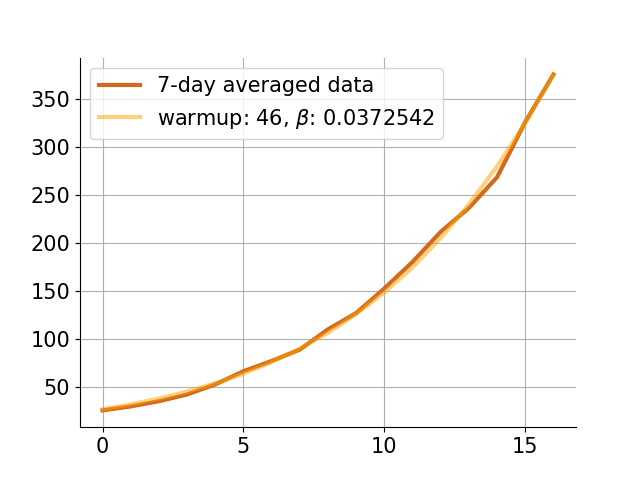

In [30]:
## SCRATCHES

warmup = 46 # 46
beta = 0.0372542 # 0.0372542
start_date = '2020-03-05' # Note: this early date is not available in the public dataset
end_beta = '2020-03-21' # final day before measures take effect. Seems rather late?
ts = timeseries[start_date:end_beta].squeeze().values

plt.close()
plt.plot(ts,color='chocolate',label='7-day averaged data')

betas = np.linspace(0.037, 0.039, 100)
warmups = np.linspace(40, 50, 11)

model_wave1.parameters.update({'beta' : beta})
out = model_wave1.sim(int(len(ts)+warmup-1), start_date=start_date, warmup=warmup)
plt.plot(out['H_in'].sum(dim='Nc')[warmup:], color='orange', alpha=.5,label=f'warmup: {warmup}, $\\beta$: {beta}')
    
plt.legend()
plt.show()

**Verify that avoiding the zero-point of the Poisson distribution doesn't significantly affect the extremum's location**

<IPython.core.display.Javascript object>


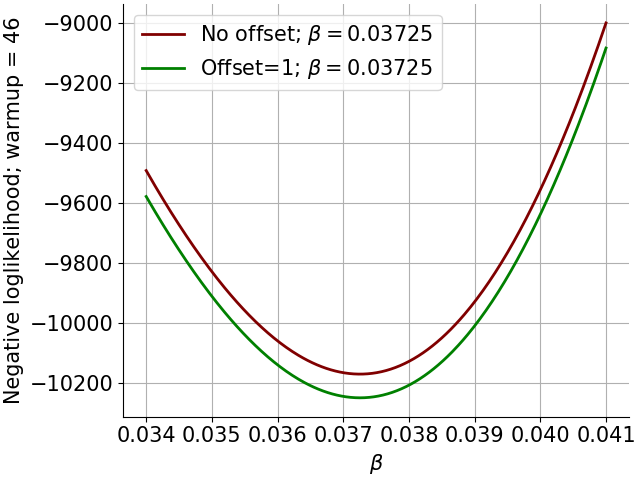

In [32]:
betas = np.linspace(0.034, 0.041, 300)
warmups = np.linspace(40, 50, 11)

MLEs = []
MLEs_offset = []
for beta in betas:
    thetas = [warmup, beta]
    states = [['H_in']]
    parNames = ['warmup','beta']
    value = MLE(thetas, model_wave1, [ts], states, parNames, start_date=start_date,poisson_offset=0)
    MLEs.append(value)
    value = MLE(thetas, model_wave1, [ts], states, parNames, start_date=start_date,poisson_offset=1)
    MLEs_offset.append(value)

no_offset_max = round(betas[MLEs.index(min(MLEs))],5)
offset_max = round(betas[MLEs_offset.index(min(MLEs_offset))],5)
    
plt.close()
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.plot(betas, MLEs, color='maroon', linewidth=2, label=f'No offset; $\\beta = {no_offset_max}$')
ax1.plot(betas, MLEs_offset, color='green', linewidth=2, label=f'Offset=1; $\\beta = {offset_max}$')
plt.xlabel(r'$\beta$')
plt.ylabel(f'Negative loglikelihood; warmup = {warmup}')
plt.legend()
plt.show()

# print(f'-----------------------------------')
# print(f'beta when no offset: {no_offset_max}')
# print(f'beta when offset=1:  {offset_max}')

**Add a heat plot to determine the proper region for the global extremum**  
Note: takes a little while to load

<IPython.core.display.Javascript object>


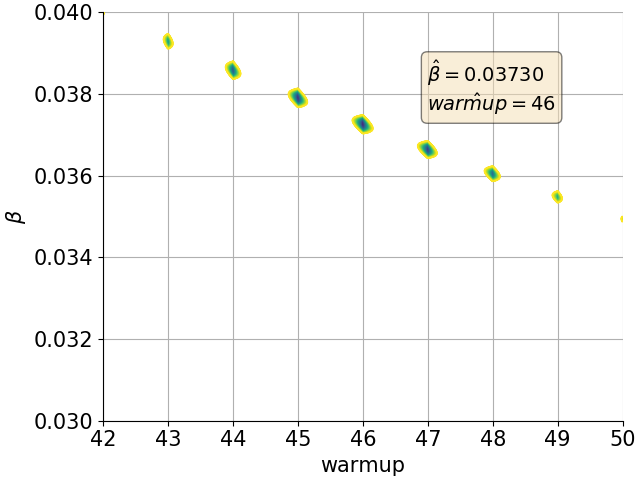

Minimal loglikelihood value: -10171.0 (goal value of PSO)
Maximal loglikelihood value: -6224.0


In [39]:
betas = np.linspace(0.030, 0.040, 300)
warmups = np.linspace(42, 50, 9)
threshold = 4

# MLEs_grid = np.zeros([len(betas), len(warmups)])
# for j, wu in enumerate(warmups):
#     for i, beta in enumerate(betas):
#         thetas = [int(wu), beta]
#         states = [['H_in']]
#         parNames = ['warmup','beta']
#         value = MLE(thetas, model_wave1, [ts], states, parNames, start_date=start_date,poisson_offset=0)
#         MLEs_grid[i,j] = value
    
plt.close()
lines = np.linspace(np.min(MLEs_grid), np.min(MLEs_grid)+threshold, 101)
fig, ax2 = plt.subplots(constrained_layout=True)
CS = ax2.contour(warmups, betas, MLEs_grid, lines, linewidths=1)
# plt.xlim([np.min(warmups)-1, np.max(warmups)+1])
plt.xlabel(f'warmup')
plt.ylabel(f'$\\beta$')

beta_min = round(betas[np.unravel_index(np.argmin(MLEs_grid),MLEs_grid.shape)[0]],4)
warmup_min = int(warmups[np.unravel_index(np.argmin(MLEs_grid),MLEs_grid.shape)[1]])

textstr = '\n'.join((
    r'$\hat{\beta} = %.5f$' % (beta_min, ),
    r'$\hat{warmup} = %.0f$' % (warmup_min, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text = ax2.text(0.70, 1, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

print(f'Minimal loglikelihood value: {round(np.min(MLEs_grid),0)} (approximate goal value of PSO)')
print(f'Maximal loglikelihood value: {round(np.max(MLEs_grid),0)}')

## Entire calibration (PSO and MCMC)

In [34]:
## First wave
start_date = '2020-03-05' # Make sure this matches with the start date of previous calculations!
end_beta = '2020-03-21'
end_ramp = '2020-05-23'#'2020-05-23'

In [37]:
from multiprocessing import Pool

In [38]:
spatial_unit = 'test_poisson'

samples_dict = full_calibration_wave1(model_wave1, timeseries, spatial_unit, start_date, end_beta, end_ramp, 
                                fig_path=fig_path, samples_path=samples_path,
                                initN=initN, Nc_total=Nc_total, dist='poisson',
                                maxiter=100, popsize=500, steps_mcmc=1000)#popsize increased to 500

Using all but one logical processors

---------------------------
CALIBRATING BETA AND WARMUP
---------------------------

1) Particle swarm optimization

No constraints given.
Best after iteration 1: [4.55404943e+01 3.72462823e-02] -10170.775967063484
Best after iteration 2: [4.55404943e+01 3.72462823e-02] -10170.775967063484
Best after iteration 3: [4.55404943e+01 3.72462823e-02] -10170.775967063484
Best after iteration 4: [4.55404943e+01 3.72462823e-02] -10170.775967063484
Best after iteration 5: [4.55404943e+01 3.72462823e-02] -10170.775967063484
New best for swarm at iteration 6: [4.62587283e+01 3.72512376e-02] -10170.780307242412
Best after iteration 6: [4.62587283e+01 3.72512376e-02] -10170.780307242412
New best for swarm at iteration 7: [4.56071311e+01 3.72555350e-02] -10170.78112288718
Best after iteration 7: [4.56071311e+01 3.72555350e-02] -10170.78112288718
Best after iteration 8: [4.56071311e+01 3.72555350e-02] -10170.78112288718
Best after iteration 9: [4.56071311e+01 3.72

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:30<00:00,  6.76it/s]


---------------------------------------------------------------------------------------------------------

CALIBRATING COMPLIANCE RAMP
---------------------------

1) Particle swarm optimization


2) Markov-Chain Monte-Carlo sampling

No constraints given.
Best after iteration 1: [7.39917418 1.30574027 0.5410599 ] -75120.36235495457
Best after iteration 2: [7.39917418 1.30574027 0.5410599 ] -75120.36235495457
New best for swarm at iteration 3: [0.1        4.31995806 0.58126118] -75132.66516135348
Best after iteration 3: [0.1        4.31995806 0.58126118] -75132.66516135348
New best for swarm at iteration 4: [0.1        4.59376851 0.57539513] -75140.76679814966
Best after iteration 4: [0.1        4.59376851 0.57539513] -75140.76679814966
Best after iteration 5: [0.1        4.59376851 0.57539513] -75140.76679814966
New best for swarm at iteration 6: [0.1        4.59018677 0.56904124] -75141.70420103472
Best after iteration 6: [0.1        4.59018677 0.56904124] -75141.70420103472
New best

Best after iteration 83: [0.55437928 3.81236572 0.56591033] -75142.5201651106
Best after iteration 84: [0.55437928 3.81236572 0.56591033] -75142.5201651106
Best after iteration 85: [0.55437928 3.81236572 0.56591033] -75142.5201651106
Best after iteration 86: [0.55437928 3.81236572 0.56591033] -75142.5201651106
Best after iteration 87: [0.55437928 3.81236572 0.56591033] -75142.5201651106
Best after iteration 88: [0.55437928 3.81236572 0.56591033] -75142.5201651106
Best after iteration 89: [0.55437928 3.81236572 0.56591033] -75142.5201651106
Best after iteration 90: [0.55437928 3.81236572 0.56591033] -75142.5201651106
Best after iteration 91: [0.55437928 3.81236572 0.56591033] -75142.5201651106
Best after iteration 92: [0.55437928 3.81236572 0.56591033] -75142.5201651106
Best after iteration 93: [0.55437928 3.81236572 0.56591033] -75142.5201651106
Best after iteration 94: [0.55437928 3.81236572 0.56591033] -75142.5201651106
Best after iteration 95: [0.55437928 3.81236572 0.56591033] -751

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:13<00:00,  2.25it/s]


---------------------------------------------------------------------------------------------------------

DONE

SAMPLES DICTIONARY SAVED IN "../../data/interim/model_parameters/COVID19_SEIRD/calibrations/provinces/test_poisson_2020-12-09.json"


<IPython.core.display.Javascript object>


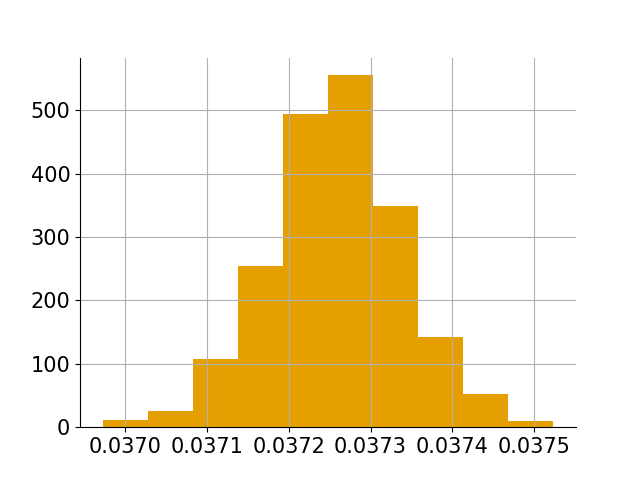

----------------------------
Average beta value:  0.03726
Warmup value:  46
----------------------------


In [86]:
fig, ax = plt.subplots()
pd.Series(samples_dict['beta']).hist(ax=ax)

print(r"----------------------------")
print(r"Average beta value: ", round(np.mean(samples_dict['beta']),5))
print(r"Warmup value: ", samples_dict['warmup'])
print(r"----------------------------")

<IPython.core.display.Javascript object>


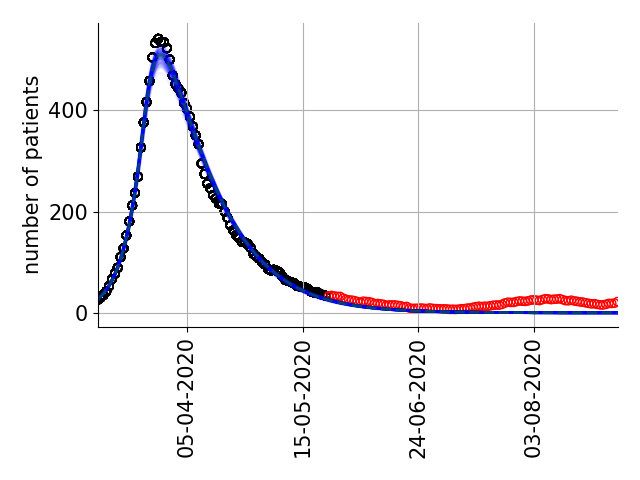

C:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


In [41]:
end_date = '2020-09-01'
plot_simulations(start_date, end_ramp, end_date, model_wave1, samples_dict, 
                timeseries, spatial_unit, n_lines=100, save=True)

# Step-by-step calibration

## Simulation until 1 July
Load the previously calculated chain data, and set the initial state of the metapopulation classes for July 1st

In [122]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/provinces/test_poisson_2020-12-09.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)
    
samples_dict_wave1.keys()

dict_keys(['warmup', 'beta', 'l', 'tau', 'prevention', 'calibration_data', 'start_date', 'end_beta', 'end_ramp', 'maxiter', 'popsize', 'steps_mcmc', 'discard', 'R0', 'R0_stratified_dict'])

<IPython.core.display.Javascript object>


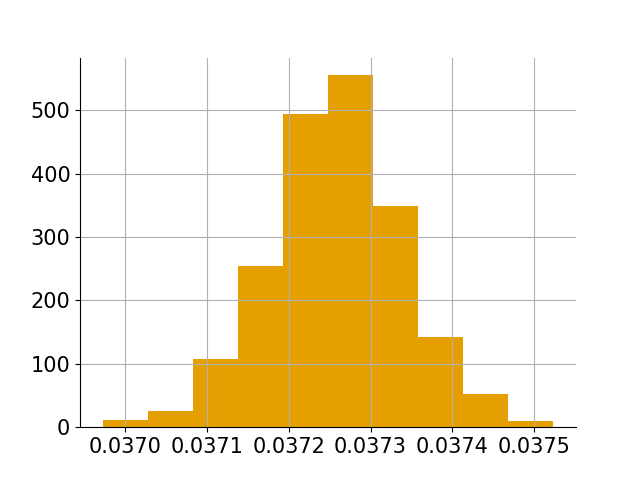

----------------------------
Average beta value:  0.03726
Warmup value:  46
----------------------------


In [123]:
fig, ax = plt.subplots()
pd.Series(samples_dict_wave1['beta']).hist(ax=ax)

print(r"----------------------------")
print(r"Average beta value: ", round(np.mean(samples_dict_wave1['beta']),5))
print(r"Warmup value: ", samples_dict_wave1['warmup'])
print(r"----------------------------")

In [124]:
# In Jenna's code, this had 100 simulations - but that's only useful for stochastic models
out_july = model_wave1.sim(time='2020-07-01', warmup=samples_dict_wave1['warmup'],start_date='2020-03-05',
                           draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)

# Select states of the final time slot (July 1st)
states = out_july.isel(time=-1)
initial_states_july1 = {key:states[key].values for key in initial_states.keys()}

In [103]:
savename = '../../data/interim/initial_states_provinces/test_poisson.npy'
np.save(savename, initial_states_july1)

## Calibration month July

In [106]:
# Load states of the metapopulation classes
loadname = '../../data/interim/initial_states_provinces/test_poisson.npy' # = savename
initial_states_july1 = np.load(loadname, allow_pickle=True).item()

<IPython.core.display.Javascript object>


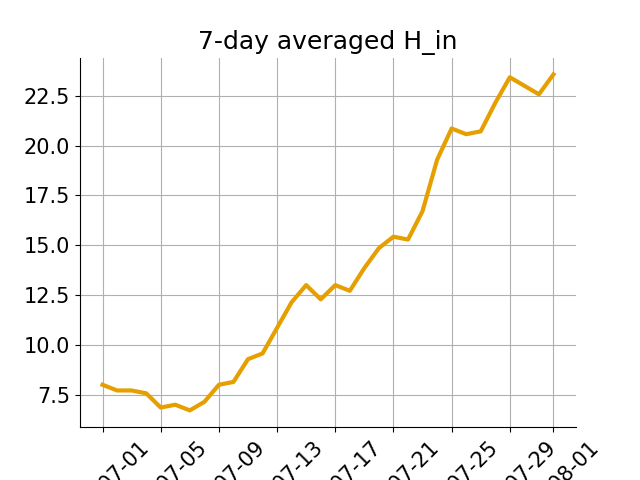

(array([737607., 737611., 737615., 737619., 737623., 737627., 737631.,
        737635., 737638.]), <a list of 9 Text xticklabel objects>)

In [121]:
# 1.5th wave date limits
start_date = '2020-07-01'
end_date = '2020-08-01'

fig, ax = plt.subplots()
ax.plot(timeseries[start_date:end_date])
plt.title('7-day averaged H_in')
plt.xticks(rotation=45)

In [126]:
# Load the default parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_july = models.COVID19_SEIRD(initial_states_july1, params)

In [129]:
spatial_unit = 'test_poisson_wave2'

In [130]:
beta_init = np.mean(samples_dict_wave1['beta'])
# sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])

In [ ]:
samples_dict_wave2 = full_calibration_wave2(model_july, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, None,None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total, dist='poisson',
                                      maxiter=100, popsize=500, steps_mcmc=1000)

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
states = [['H_in']]
end_date = end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(200):
    idx,model_july.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model_july.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim(start_date, end_date)
ax.set_ylabel('daily hospitalizations')
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

## Simulation until 1 August

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_July_2020-10-30.json', 'r') as fp:
    samples_dict_july = json.load(fp)

In [ ]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
# model.parameters['policy_time'] = samples_dict_wave1['lag_time']

In [ ]:
out_aug = model_july.sim(time='2020-08-01', excess_time=0,start_date='2020-07-01',
                   N=100, draw_fcn=draw_sample_beta_COVID19_SEIRD,samples=samples_dict_july)
states = out_aug.isel(time=-1).mean(dim="draws")
initial_states_aug1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Luik_initial_states_aug1.npy', initial_states_aug1)

## Calibration month August

In [ ]:
initial_states_aug1 = np.load('../data/interim/prediction_provinces/Luik_initial_states_aug1.npy', allow_pickle=True).item()

In [ ]:
# Second wave
start_date = '2020-08-01'
end_beta = '2020-09-01'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_aug = models.COVID19_SEIRD(initial_states_aug1, params)

In [ ]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_Aug'

In [ ]:
beta_init = np.mean(samples_dict_july['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])

In [ ]:
mu_beta, std_beta = norm.fit(samples_dict_july['beta'])
mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['sigma_data']) # should be on july!
beta_norm_params = (mu_beta, std_beta)
sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
samples_dict = full_calibration_wave2(model_aug, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,steps_mcmc=1000)

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
## Deze herrunnen!
states = [['H_in']]
end_date = end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(20):
    idx,model_aug.parameters['beta'] = random.choice(list(enumerate(samples_dict_aug['beta'])))
    y_model = model_aug.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim(start_date, end_date)
ax.set_ylabel('daily hospitalizations')
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)

## Simulation until 1 September

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_Aug_2020-10-30.json', 'r') as fp:
    samples_dict_aug = json.load(fp)

In [ ]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
# model.parameters['policy_time'] = samples_dict_wave1['lag_time']

In [ ]:
out_sept = model_aug.sim(time='2020-09-01', excess_time=0,start_date='2020-08-01',
                   N=100, draw_fcn=draw_sample_beta_COVID19_SEIRD,samples=samples_dict_aug)
states = out_sept.isel(time=-1).mean(dim="draws")
initial_states_sept1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Luik_initial_states_sept1.npy', initial_states_sept1)

In [ ]:
initial_states_sept1

## Calibration month September

In [ ]:
initial_states_sept1 = np.load('../data/interim/prediction_provinces/Luik_initial_states_sept1.npy', allow_pickle=True).item()

In [ ]:
# Second wave
start_date = '2020-09-01'
end_beta = '2020-10-01'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_sept = models.COVID19_SEIRD(initial_states_sept1, params)

In [ ]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_Sept'

In [ ]:
beta_init = 0.03
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])

In [ ]:
# mu_beta, std_beta = norm.fit(samples_dict_aug['beta'])
# mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['sigma_data']) # should be on aug!
# beta_norm_params = (mu_beta, std_beta)
# sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
samples_dict = full_calibration_wave2(model_aug, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,steps_mcmc=1000)

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
states = [['H_in']]
end_date = end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(20):
    idx,model_sept.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model_sept.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim(start_date, end_date)
ax.set_ylabel('daily hospitalizations')
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

# Calibration on October

## Simulation until end September

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Hainaut_wave1_2020-11-03.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [ ]:
states = [['H_in']]
end_date = '2020-09-28'
data=[timeseries[start_date:end_ramp].values]

fig,ax=plt.subplots()
for i in range(20):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict_wave1['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict_wave1['l'])))
    model.parameters['tau'] = samples_dict_wave1['tau'][idx]
    model.parameters['policy_time'] = samples_dict_wave1['warmup']
    model.parameters['prevention'] = samples_dict_wave1['prevention'][idx]
    y_model = model.sim(time=end_date, excess_time=samples_dict_wave1['warmup'], start_date=start_date)
    ax = plot_fit(y_model,data,start_date,samples_dict_wave1['warmup'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-03-10', end_date)

In [ ]:
out_sept28 = model.sim(time='2020-09-28', excess_time=samples_dict_wave1['warmup'],start_date='2020-03-15',
                   N=10, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_sept28.isel(time=-1).mean(dim="draws")
initial_states_sept28 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
out_sept28.isel(time=-1).mean(dim="draws")

In [ ]:
np.save('../data/interim/prediction_provinces/Hainaut_initial_states_Sept28.npy', initial_states_sept28)

## Calibration starting September 28

In [ ]:
initial_states_sept28 = np.load('../data/interim/prediction_provinces/Hainaut_initial_states_Sept28.npy', allow_pickle=True).item()

In [ ]:
initial_states_sept28

In [ ]:
# Second wave
start_date = '2020-09-28'
end_beta = '2020-10-30'

In [ ]:
len(Hainaut_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
model = models.COVID19_SEIRD(initial_states_sept28, params)

In [ ]:
# function parameters 
timeseries = Hainaut_ts['NEW_IN']
spatial_unit = 'Hainaut_wave2_from_sept28'


In [ ]:
# mu_beta, std_beta = norm.fit(samples_dict_wave1['beta'])
# mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['beta'])
# beta_norm_params = (mu_beta, std_beta)
# sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
beta_init = np.mean(samples_dict_wave1['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])


In [ ]:
samples_dict = full_calibration_wave2(model, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total, 
                                      maxiter=100, popsize=200, steps_mcmc=1000)

In [ ]:
fig, ax = plt.subplots()
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
states = [['H_in']]
end_date = '2021-01-01' #end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(20):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-09-01', '2021-01-01')
ax.set_ylabel('daily hospitalizations')
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)

In [ ]:
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

# Calibration from August 1

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/COVID19_SEIRD/calibrations/provinces/Hainaut_wave1_2020-11-04.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

## Simulation until August 1 with policies

In [ ]:
out_aug1 = model_wave1_with_policies.sim(time='2020-08-01', excess_time=samples_dict_wave1['warmup'],start_date='2020-03-15',
                   N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_aug1.isel(time=-1).mean(dim="draws")
initial_states_aug1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Hainaut_initial_states_Aug1.npy', initial_states_aug1)

## Simulation until August 1 without policies

In [ ]:
out_aug1 = model_wave1.sim(time='2020-08-01', excess_time=samples_dict_wave1['warmup'],start_date='2020-03-15',
                   N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_aug1.isel(time=-1).mean(dim="draws")
initial_states_aug1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/initial_states_provinces/'+spatial_unit+'_Aug1.npy', initial_states_aug1)

## Calibration starting August 1

In [ ]:
initial_states_aug1 = np.load('../data/interim/initial_states_provinces/Hainaut_wave1_Aug1.npy', allow_pickle=True).item()

In [ ]:
# Second wave
start_date = '2020-08-01'
end_beta = '2020-10-31'

In [ ]:
len(Hainaut_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
model_wave2_from_aug1 = models.COVID19_SEIRD(initial_states_aug1, params)

In [ ]:
# mu_beta, std_beta = norm.fit(samples_dict_wave1['beta'])
# mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['beta'])
# beta_norm_params = (mu_beta, std_beta)
# sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
beta_init = np.mean(samples_dict_wave1['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])


In [ ]:
spatial_unit = 'Hainaut_wave2_from_aug1_no_policies_10000'
samples_dict = full_calibration_wave2(model_wave2_from_aug1, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total, pso=False,
                                      maxiter=100, popsize=200, steps_mcmc=10000)

In [ ]:
fig, ax = plt.subplots()
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
end_date = '2021-01-01'
plot_simulations(start_date, end_ramp, end_date, model_wave2_from_aug1, samples_dict, 
                timeseries, spatial_unit, n_lines=200, save=True)